In [1]:
import torch
import torch.nn as nn
from transformers import SamModel, SamConfig

class HyperspectralSAM(nn.Module):
    def __init__(self, sam_checkpoint="facebook/sam-vit-base", num_input_channels=12):
        """
        Adapt SAM for hyperspectral data by modifying the input layer to handle more channels
        and adding a final layer for binary segmentation.

        Args:
            sam_checkpoint (str): Hugging Face SAM model checkpoint.
            num_input_channels (int): Number of input channels for hyperspectral data.
        """
        super(HyperspectralSAM, self).__init__()

        config = SamConfig.from_pretrained(sam_checkpoint)
        config.vision_config.num_channels = num_input_channels

        self.sam_model = SamModel.from_pretrained(sam_checkpoint, config=config, ignore_mismatched_sizes=True)

        # Modify the vision encoder's first convolutional layer
        original_conv = self.sam_model.vision_encoder.patch_embed.projection
        new_conv = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        self.sam_model.vision_encoder.patch_embed.projection = new_conv

        # Add a final convolutional layer for binary segmentation
        self.final_conv = nn.Conv2d(
            in_channels=3,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, pixel_values, input_points=None, input_boxes=None, input_masks=None):
        """
        Forward pass for the adapted SAM model.

        Args:
            pixel_values (torch.Tensor): Input tensor of shape (batch_size, num_channels, height, width).
            input_points (torch.Tensor, optional): Points as input prompts, of shape (batch_size, num_points, 2).
            input_boxes (torch.Tensor, optional): Boxes as input prompts, of shape (batch_size, num_boxes, 4).
            input_masks (torch.Tensor, optional): Masks as input prompts, of shape (batch_size, height, width).

        Returns:
            torch.Tensor: Binary segmentation logits of shape (batch_size, 1, height, width).
        """
        outputs = self.sam_model(
            pixel_values=pixel_values,
            input_points=input_points,
            input_boxes=input_boxes,
            input_masks=input_masks
        )

        logits = self.final_conv(outputs["pred_masks"][:, 0, :, :, :])
        return {"pred_masks": logits}


In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from PIL import Image
import json
import warnings

class HyperspectralExpandedDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Root directory containing the expanded dataset.
        """
        self.root_dir = root_dir
        self.samples = self._load_samples()

    def _load_samples(self):
        """
        Scans the directory structure to find all saved samples.

        Returns:
            list: List of dictionaries containing file paths for each sample.
        """
        samples = []
        for sample_name in os.listdir(self.root_dir):
            sample_path = os.path.join(self.root_dir, sample_name)
            if not os.path.isdir(sample_path):
                continue

            # Collect file paths for bands, binary mask, and prompt
            bands_path = os.path.join(sample_path, "bands.pt")
            mask_path = os.path.join(sample_path, "binary_mask.tif")
            prompt_path = os.path.join(sample_path, "prompt.json")

            if os.path.exists(bands_path) and os.path.exists(mask_path) and os.path.exists(prompt_path):
                samples.append({
                    "bands": bands_path,
                    "mask": mask_path,
                    "prompt": prompt_path
                })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Loads a sample.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (prompt, bands, binary_mask)
        """
        sample = self.samples[idx]

        bands = None
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.load.*")
            bands = torch.load(sample["bands"])

        binary_mask = to_tensor(Image.open(sample["mask"])).squeeze(0)  # Remove channel dimension

        with open(sample["prompt"], "r") as f:
            prompt = json.load(f)

        return prompt, bands, binary_mask


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from transformers import SamModel, SamConfig

# Initialize dataset and split into training and evaluation sets
root_dir = "./expanded_dataset_output"
dataset = HyperspectralExpandedDataset(root_dir=root_dir)

# Split dataset: 90% training, 10% evaluation
train_size = int(0.9 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# DataLoaders
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

In [4]:
print(len(dataset))

10505


In [5]:
for (prompt, img, mask) in train_loader:
    print(prompt)
    print(img.shape)
    print(mask.shape)
    break

{'centroid': [tensor([15.4310, 40.5926], dtype=torch.float64), tensor([108.8151, 117.7778], dtype=torch.float64)], 'random_point': [tensor([18, 39]), tensor([114, 119])]}
torch.Size([2, 12, 120, 120])
torch.Size([2, 120, 120])


In [6]:
from torchvision.transforms import Resize
from tqdm import tqdm

def train_model(train_loader, model, optimizer, criterion, device):
    """
    Training loop for a model that processes image, mask, and prompt data from a train loader.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        model (torch.nn.Module): Model to train.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to use for training ('cuda' or 'cpu').

    Returns:
        None
    """
    model.train()  # Set the model to training mode
    total_loss = 0.0

    # Resize transformations
    resize_img = Resize((1024, 1024))  # Resize input images to 1024x1024

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", unit="batch")

    for batch_idx, (prompt, img, mask) in progress_bar:
        img = resize_img(img)  # Resize input images to 1024x1024

        # Zip the random_point on the fly
        random_point_x, random_point_y = prompt['random_point']
        random_point = torch.stack((random_point_x, random_point_y), dim=-1)

        # Reshape to [batch_size, point_batch_size, nb_points_per_image, 2]
        batch_size = img.shape[0]
        random_point = random_point.view(batch_size, 1, nb_points_per_image, 2)

        # Ensure inputs are on the correct device
        img = img.to(device)
        mask = mask.to(device)
        random_point = random_point.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(img, input_points=random_point)

        # Resize mask to match prediction size
        predictions_shape = predictions["pred_masks"].shape[-2:]  # (height, width)
        resize_mask = Resize(predictions_shape)  # Dynamically adjust mask size
        mask = resize_mask(mask)

        loss = criterion(predictions["pred_masks"], mask.unsqueeze(1).float())
        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    # Average loss over all batches
    avg_loss = total_loss / len(train_loader)
    print(f"Training completed. Average Loss: {avg_loss}")

In [7]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def evaluate(model, eval_loader, criterion, device, num_samples=4):
    """
    Evaluate the model on the evaluation dataset and visualize random samples.

    Args:
        model (nn.Module): The trained model.
        eval_loader (DataLoader): DataLoader for the evaluation dataset.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the evaluation on.
        num_samples (int): Number of samples to visualize.

    Returns:
        float: Average evaluation loss.
    """
    model.eval()
    eval_loss = 0.0

    predictions = []
    real_masks = []
    inputs = []

    with torch.no_grad():
        for prompts, bands, binary_masks in tqdm(eval_loader, desc="Evaluating"):
            # Resize inputs to 1024x1024
            resize_img = Resize((1024, 1024))
            bands = resize_img(bands).to(device)
            binary_masks = binary_masks.to(device)

            # Extract random points from the prompts
            random_point_x, random_point_y = prompts['random_point']
            random_point = torch.stack((random_point_x, random_point_y), dim=-1)
            batch_size = bands.shape[0]
            nb_points_per_image = random_point.shape[0] // batch_size
            random_point = random_point.view(batch_size, 1, nb_points_per_image, 2).to(device)

            # Forward pass
            outputs = model(bands, input_points=random_point)
            logits = outputs["pred_masks"]

            # Resize mask to match prediction size
            predictions_shape = logits.shape[-2:]
            resize_mask = Resize(predictions_shape)
            binary_masks = resize_mask(binary_masks)

            # Compute loss
            loss = criterion(logits, binary_masks.unsqueeze(1).float())
            eval_loss += loss.item()

            # Collect predictions and corresponding inputs
            preds = 255*(torch.sigmoid(logits) > 0.5).cpu()
            predictions.extend(preds)
            real_masks.extend(binary_masks.cpu())
            inputs.extend(bands.cpu())

    eval_loss /= len(eval_loader)
    print(f"Evaluation Loss: {eval_loss:.4f}")
    return eval_loss


def visualize_samples(inputs, predictions, real_masks):
    """
    Visualize random samples with predictions and ground truth masks.

    Args:
        inputs (list): List of input images (bands).
        predictions (list): List of predicted masks.
        real_masks (list): List of ground truth masks.
    """
    num_samples = len(inputs)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    if num_samples == 1:
        axes = [axes]  # Ensure axes are iterable for a single sample

    for i, (input_tensor, pred_mask, real_mask) in enumerate(zip(inputs, predictions, real_masks)):
        ax_input, ax_pred, ax_real = axes[i]

        # Display the input image
        input_image = to_pil_image(input_tensor[1:4])
        ax_input.imshow(input_image)
        ax_input.set_title("Input Image")
        ax_input.axis("off")

        # Display the predicted mask
        ax_pred.imshow(pred_mask.squeeze(0), cmap="gray")
        ax_pred.set_title("Predicted Mask")
        ax_pred.axis("off")

        # Display the real mask
        ax_real.imshow(real_mask.squeeze(0), cmap="gray")
        ax_real.set_title("Real Mask")
        ax_real.axis("off")

    plt.tight_layout()
    plt.show()


In [8]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HyperspectralSAM(num_input_channels=12).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation masks
optimizer = optim.Adam(model.parameters(), lr=5e-5)

Some weights of SamModel were not initialized from the model checkpoint at facebook/sam-vit-base and are newly initialized because the shapes did not match:
- vision_encoder.patch_embed.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 12, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Train the model
last_successful_saved_epoch = 1
model_path = f"models/hyperspectral_sam_epoch_{last_successful_saved_epoch}.pth"
model.load_state_dict(torch.load(model_path))
model = model.to(device)

/tmp/ipykernel_6287/1802415147.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


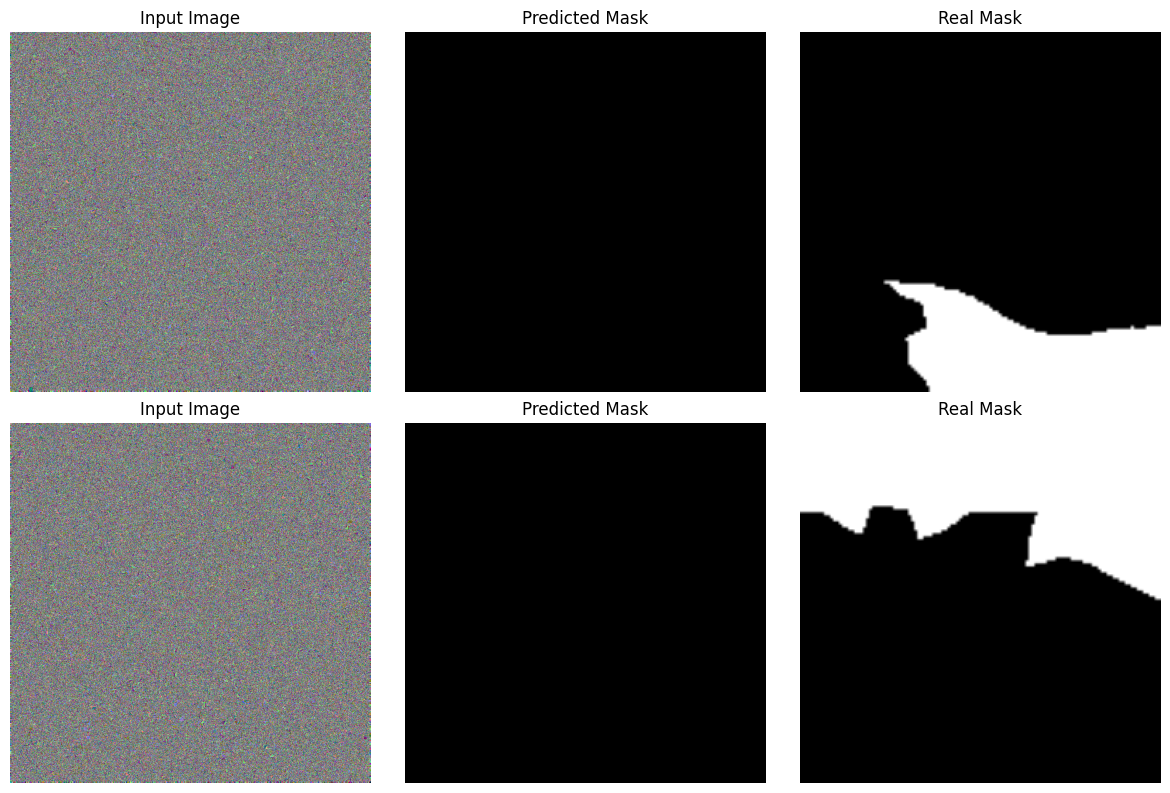

In [14]:
for prompts, bands, binary_masks in eval_loader:
    model.eval()
    resize_img = Resize((1024, 1024))
    bands = resize_img(bands).to(device)
    binary_masks = binary_masks.to(device)
    
    # Extract random points from the prompts
    random_point_x, random_point_y = prompts['random_point']
    random_point = torch.stack((random_point_x, random_point_y), dim=-1)
    batch_size = bands.shape[0]
    nb_points_per_image = random_point.shape[0] // batch_size
    random_point = random_point.view(batch_size, 1, nb_points_per_image, 2).to(device)

    # Forward pass
    outputs = model(bands, input_points=random_point)
    logits = outputs["pred_masks"]

    # Resize mask to match prediction size
    predictions_shape = logits.shape[-2:]
    resize_mask = Resize(predictions_shape)
    binary_masks = resize_mask(binary_masks)

    preds = 255*(torch.sigmoid(logits) > 0.5).cpu()  # Threshold at 0.5 for binary masks
    
    visualize_samples(bands.cpu(), preds.cpu(), binary_masks.cpu())
    model.train()
    break

In [ ]:
epochs = 10
for epoch in range(epochs):
    train_model(train_loader, model, optimizer, criterion, device)
    model_path = f"models/hyperspectral_sam_epoch_{last_successful_saved_epoch+epoch+1}.pth"
    torch.save(model.state_dict(), model_path)

Training:  10%|▉         | 454/4727 [04:44<44:38,  1.60batch/s, loss=0.239] 